In [45]:
#SERVER

class Server:
    def __init__(self, server_id, ip_address, total_cpu, total_memory, total_bandwidth, network_distance, hosted_services=None):
        self.server_id = server_id
        self.network_distance = network_distance
        self.ip_address = ip_address
        self.total_cpu = total_cpu
        self.total_memory = total_memory
        self.total_bandwidth = total_bandwidth
        self.available_cpu = total_cpu  # Initially, all resources are available
        self.available_memory = total_memory
        self.available_bandwidth = total_bandwidth
        self.hosted_services = hosted_services if hosted_services is not None else []

    def calculate_agg_resources(self):
        """Calculate the average resource utilization as an aggregate metric."""
        return (self.available_cpu + self.available_memory + self.available_bandwidth) / 3

    
    def add_service_function(self, service_function):
        self.hosted_services.append(service_function)

    def remove_service_function(self, service_function):
        self.hosted_services.remove(service_function)

    def list_service_functions(self):
        return self.hosted_services
    
    def calculate_latency_priority(self, microservice):
        """Simulate latency based on network distance and server load, in real life we would have the microservice ping the server."""
        base_latency = self.network_distance * 0.5  # Simplified calculation
        return base_latency
    
    def meets_requirements(self, cpu_requirement, memory_requirement, bandwidth_requirement):
        """Check if the server has enough resources to host the microservice."""
        return (self.available_cpu >= cpu_requirement and
                self.available_memory >= memory_requirement and
                self.available_bandwidth >= bandwidth_requirement)
    def deploy_microservice(self, microservice):
        #Deploy service and subtract required resources
        if not self.meets_requirements(microservice.cpu_requirement, microservice.memory_requirement, microservice.bandwidth_requirement):
            return False  # Deployment fails due to insufficient resources
        
        self.available_cpu -= microservice.cpu_requirement
        self.available_memory -= microservice.memory_requirement
        self.available_bandwidth -= microservice.bandwidth_requirement
        self.hosted_services.append(microservice.service_id)
        microservice.server=self
        return True

    def remove_microservice(self, microservice):
        #remove a service and re-add used resources to server
        if microservice.service_id in self.hosted_services:
            self.available_cpu += microservice.cpu_requirement
            self.available_memory += microservice.memory_requirement
            self.available_bandwidth += microservice.bandwidth_requirement
            self.hosted_services.remove(microservice.service_id)
            microservice.server= None

    def __str__(self):
        return (f"Server(ID={self.server_id}, IP={self.ip_address}, "
                f"CPU={self.available_cpu}, Memory={self.available_memory}, "
                f"Bandwidth={self.available_bandwidth}, Distance={self.network_distance}, "
                f"Hosted_Services={len(self.hosted_services)})")

       


In [ ]:

#MICROSERVICE  
class Microservice:
    def __init__(self, service_id, name, cpu_requirement, memory_requirement, bandwidth_requirement, latency_threshold, server=None):
        self.service_id = service_id
        self.name = name
        self.cpu_requirement = cpu_requirement
        self.memory_requirement = memory_requirement
        self.bandwidth_requirement = bandwidth_requirement
        self.latency_threshold = latency_threshold
        self.server = server  # HOST SERVER

    def __str__(self):
        server_id = self.server.server_id if self.server else "Not deployed"
        return (f"Microservice(name={self.name}, CPU={self.cpu_requirement}, "
                f"Memory={self.memory_requirement}, Bandwidth={self.bandwidth_requirement}, "
                f"Latency Threshold={self.latency_threshold}ms, Server={server_id})")



In [ ]:


# GRAPH
import numpy as np
import heapq
import networkx as nx
import matplotlib.pyplot as plt
class NetworkGraph:
    def __init__(self):
        self.nodes = {}  # Stores server objects with server_id as key
        self.edges = {}  # Stores connections and their properties

    def add_server(self, server):
        """Add a server"""
        self.nodes[server.server_id] = server
        self.edges[server.server_id] = []

    def connect_servers(self, server_id1, server_id2, latency, bandwidth):
        """Connect two servers with specified latency and bandwidth."""
        if server_id1 not in self.nodes or server_id2 not in self.nodes:
            raise ValueError("One or both of the servers not found in the graph.")
        
        connection_info = {'latency': latency, 'bandwidth': bandwidth}
        self.edges[server_id1].append((server_id2, connection_info))
        self.edges[server_id2].append((server_id1, connection_info))

    def get_server_connections(self, server_id):
        """Retrieve a server's connections and their properties."""
        return self.edges.get(server_id, [])

    def __str__(self):
        """Provide a string overload of the graph for debugging purposes."""
        description = "Network Graph:\n"
        for server_id in self.nodes:
            description += f"Server {server_id} connections: {self.edges[server_id]}\n"
        return description
    
    def find_shortest_path(self, start_server_id, end_server_id):
        """Find the shortest path from start to end server based on latency using Dijkstra"""
        distances = {server_id: float('inf') for server_id in self.nodes}
        distances[start_server_id] = 0
        priority_queue = [(0, start_server_id)]
        predecessor = {server_id: None for server_id in self.nodes}

        while priority_queue:
            current_distance, current_server_id = heapq.heappop(priority_queue)
            if current_server_id == end_server_id:
                break

            for neighbor, connection_info in self.get_server_connections(current_server_id):
                distance = current_distance + connection_info['latency']
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    predecessor[neighbor] = current_server_id
                    heapq.heappush(priority_queue, (distance, neighbor))

        # Reconstructing path
        path = []
        current = end_server_id
        while current is not None:
            path.append(current)
            current = predecessor[current]
        path.reverse()

        return path if path[0] == start_server_id else None
    
    def average_network_latency(self):
        """Calculate the average latency across all connections in the graph."""
        total_latency, count = 0, 0
        for server_id in self.edges:
            for connection in self.edges[server_id]:
                _, connection_info = connection
                total_latency += connection_info['latency']
                count += 1
        return total_latency / count if count > 0 else 0
    

    def update_connection(self, server_id1, server_id2, latency=None, bandwidth=None):
        """Update the properties of a connection between two servers."""
        if server_id1 in self.edges and server_id2 in self.edges:
            for i, (target_id, info) in enumerate(self.edges[server_id1]):
                if target_id == server_id2:
                    if latency is not None:
                        self.edges[server_id1][i][1]['latency'] = latency
                    if bandwidth is not None:
                        self.edges[server_id1][i][1]['bandwidth'] = bandwidth
                    break
            # Bidirectional repeat for the reverse connection
            for i, (target_id, info) in enumerate(self.edges[server_id2]):
                if target_id == server_id1:
                    if latency is not None:
                        self.edges[server_id2][i][1]['latency'] = latency
                    if bandwidth is not None:
                        self.edges[server_id2][i][1]['bandwidth'] = bandwidth
                    break
        else:
            raise ValueError("One or both of the servers not found in the graph.")
        

    def calculate_load_imbalance(self):
        """
        Calculate the imbalance in server load across the network.
        
        Returns a dictionary with the standard deviation of CPU, memory, and bandwidth utilizations,
            indicating the level of imbalance. Lower values indicate a more balanced load.
        """
        cpu_utilizations = []
        memory_utilizations = []
        bandwidth_utilizations = []
        
        for server_id, server in self.nodes.items():
            cpu_util = (server.total_cpu - server.available_cpu) / server.total_cpu if server.total_cpu else 0
            memory_util = (server.total_memory - server.available_memory) / server.total_memory if server.total_memory else 0
            bandwidth_util = (server.total_bandwidth - server.available_bandwidth) / server.total_bandwidth if server.total_bandwidth else 0
            
            cpu_utilizations.append(cpu_util)
            memory_utilizations.append(memory_util)
            bandwidth_utilizations.append(bandwidth_util)
        
        # Calculate standard deviation for each resource utilization
        cpu_std = np.std(cpu_utilizations) if cpu_utilizations else 0
        memory_std = np.std(memory_utilizations) if memory_utilizations else 0
        bandwidth_std = np.std(bandwidth_utilizations) if bandwidth_utilizations else 0
        
        return {
            'cpu_std': cpu_std,
            'memory_std': memory_std,
            'bandwidth_std': bandwidth_std
        }
    def get_average_latency_to_other_servers(self, server_id):
        """Calculate the average latency from a specified server to all other servers."""
        if server_id not in self.edges:
            raise ValueError(f"Server {server_id} not found in the graph.")
        
        total_latency = 0
        connections = 0
        for connection in self.edges[server_id]:
            neighbor_id, connection_info = connection
            total_latency += connection_info['latency']
            connections += 1
        
        # We don't divide by zero if a server has no connections
        if connections == 0:
            return float('inf')  
        
        return total_latency / connections
    
    def visualize(self):
        """Visualize the network graph."""
        G = nx.Graph()
        for server_id in self.nodes:
            G.add_node(server_id)
        for server_id, connections in self.edges.items():
            for target_id, info in connections:
                G.add_edge(server_id, target_id, weight=info['latency'])
        
        pos = nx.spring_layout(G)  # positions for all nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_edges(G, pos, width=2)
        nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
        
        edge_labels = dict([((u, v,), f"{d['weight']}ms")
                            for u, v, d in G.edges(data=True)])
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        
        plt.axis('off')
        plt.show()



In [ ]:


#ENVIRONMENT

class MicroserviceDeploymentEnv:
    def __init__(self, graph, microservices):
        self.graph = graph  
        self.microservices = microservices
        self.current_microservice = None
        self.state_size = None
        self.action_size = len(graph.nodes)  # Dynamically determined by the number of servers in the graph

  

    @staticmethod        
    def  normalize(value, min_value, max_value):
        """Normalize a value to 0-1 range for optimal dqn input"""

        return (value - min_value) / (max_value - min_value) if max_value > min_value else 0
    

    def get_state(self, microservice):
        state = []
        # Add server states
        for server_id, server in self.graph.nodes.items():
            normalized_cpu = self.normalize(server.available_cpu, 0, server.total_cpu)
            normalized_memory = self.normalize(server.available_memory, 0, server.total_memory)
            normalized_bandwidth = self.normalize(server.available_bandwidth, 0, server.total_bandwidth)

            server_state = [
                normalized_cpu,  
                normalized_memory,
                normalized_bandwidth,
                self.graph.get_average_latency_to_other_servers(server_id)
            ]
            state.extend(server_state)
        # Add microservice requirements
        microservice_state = [
            microservice.cpu_requirement,
            microservice.memory_requirement,
            microservice.bandwidth_requirement,
            microservice.latency_threshold
        ]
        # Normalize and add to state
        state.extend([self.normalize(val, min_val, max_val) for val, min_val, max_val in zip(microservice_state, min_vals, max_vals)])
        # Add global network metric
        state.append(self.graph.average_network_latency())
        return state

    def execute_action(self, action):
        # Action is the index corresponding to a server in the graph.nodes dictionary
        server_ids = list(self.graph.nodes.keys())
        try:
            selected_server_id = server_ids[action] 
            selected_server = self.graph.nodes[selected_server_id]
            #deploy the microservice to the selected server
            if self.current_microservice and selected_server.meets_requirements(
                self.current_microservice.cpu_requirement,
                self.current_microservice.memory_requirement,
                self.current_microservice.bandwidth_requirement
            ):
                success = selected_server.deploy_microservice(self.current_microservice)
                if success:
                    return self.calculate_reward(action, success)  # Return True if deployment is successful
                
        except IndexError:
            # Handle invalid action (e.g., action index out of range)
            pass

        return self.calculate_reward(action, success=False)   # Return False if deployment fails or is invalid
    
    def calculate_reward(self, action, success):
        """
        Calculate the reward for deploying a microservice based on the action's success and system state.
        
        Parameters:
            action (int): The destination server of the action attempted
            success: Whether the microservice deployment was successful.
        
        Returns the calculated reward for the action.
             
        """
        if not self.current_microservice:
            # No microservice is selected for deployment...system error.
            return -10  # Penalize heavily
        
        server_ids = list(self.graph.nodes.keys())
        try:
            selected_server_id = server_ids[action]
            selected_server = self.graph.nodes[selected_server_id]
        except IndexError:
            # Action led to an invalid server selection
            return -5
        
        if not success:
            # Deployment failed. Penalize to a degree but less than system errors.
            return -2

        # If deployment was successful, positive reward is calculated based on several factors, we can supplement it if necessary
        reward = 0
        
        # Factor 1: Resource Utilization Efficiency. Encourage efficient use of server resources without overloading.

        cpu_utilization = (selected_server.total_cpu - selected_server.available_cpu) / selected_server.total_cpu
        memory_utilization = (selected_server.total_memory - selected_server.available_memory) / selected_server.total_memory
        bandwidth_utilization = (selected_server.total_bandwidth - selected_server.available_bandwidth) / selected_server.total_bandwidth
        
        # Average utilization leads to balanced use of resources.
        avg_utilization = (cpu_utilization + memory_utilization + bandwidth_utilization) / 3
        reward += 5 * avg_utilization  
        
        # Factor 2: Network Performance. Penalize if the deployment significantly impacts network latency or does not meet latency requirements.

        if selected_server.calculate_latency_priority(self.current_microservice) > self.current_microservice.latency_threshold:
            # Penalize for exceeding latency threshold, scaled by how much it was exceeded.
            reward -= 5 * (selected_server.calculate_latency_priority(self.current_microservice) / self.current_microservice.latency_threshold)
        
        # Factor 3: Load Balancing. Reward deployments that help balance the load across the network.
        
        
        load_imbalance = self.graph.calculate_load_imbalance()  # Assess load balance across servers.
        avg_imbalance = (load_imbalance['cpu_std'] + load_imbalance['memory_std'] + load_imbalance['bandwidth_std']) / 3

        reward -= 2 * avg_imbalance  # Penalize based on degree of imbalance to encourage load balancing.
        
        # OTHERS
        
        return reward




Deploying service1 to server at index 2
Deployment result: 1.1269974884494265
Deploying service2 to server at index 2
Deployment result: 3.155592967658395
Deploying service3 to server at index 2
Deployment result: -2
Deploying service4 to server at index 2
Deployment result: -2
Deploying service5 to server at index 2
Deployment result: -2
Deploying service6 to server at index 1
Deployment result: 1.8559486606188593

Testing special scenarios:

Deploying a microservice with requirements exceeding any server's capacity...
Deployment result for big service to server at index 2: -2

Attempting to deploy to an invalid server index...
Deployment result for invalid index: -5

Deploying microservice with specific requirements not met by the chosen server...
Deployment result for specific service to server at index 0 (requirements not met): -2


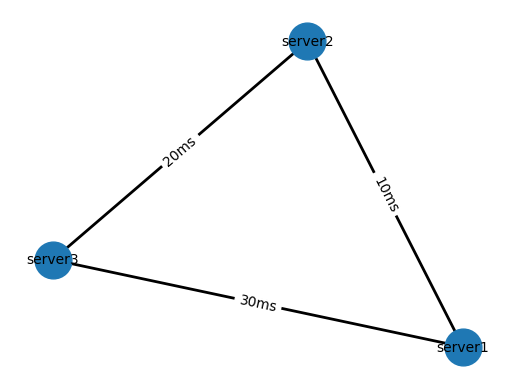


Listing all servers and deployed microservices:
Server server1 (10.0.0.1): Deployed Microservices -> []
Server server2 (10.0.0.2): Deployed Microservices -> ['service6']
Server server3 (10.0.0.3): Deployed Microservices -> ['service1', 'service2']


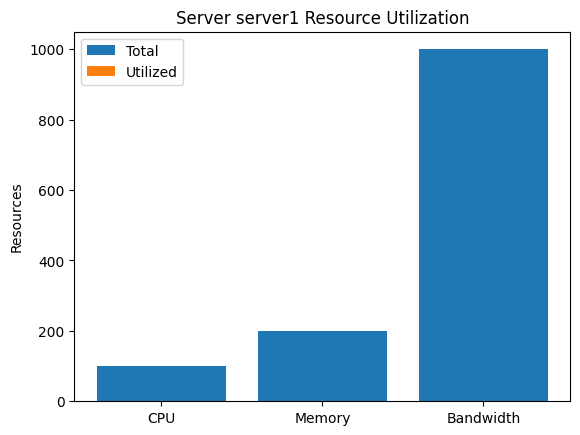

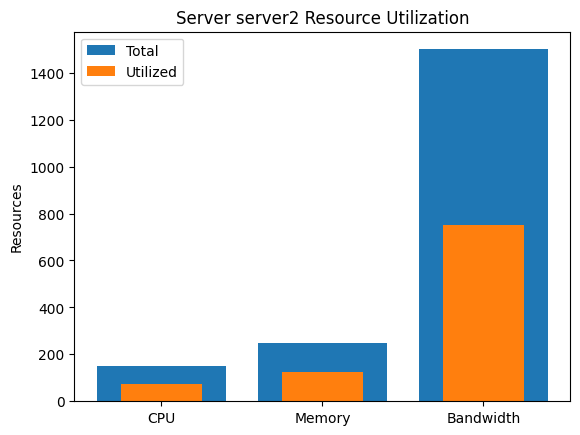

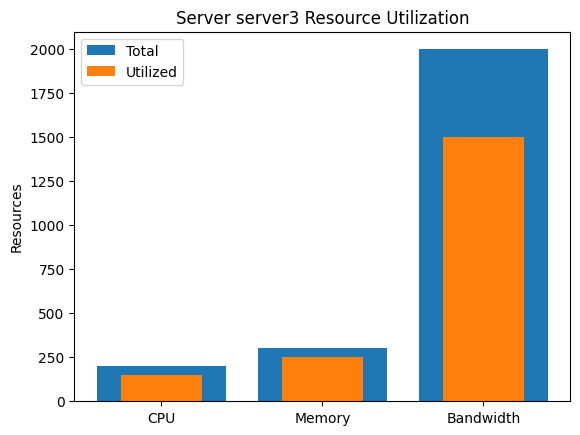

In [54]:
import random
import numpy as np
import matplotlib.pyplot as plt


network_graph = NetworkGraph()

network_graph.add_server(Server("server1", "10.0.0.1", 100, 200, 1000, 5))
network_graph.add_server(Server("server2", "10.0.0.2", 150, 250, 1500, 10))
network_graph.add_server(Server("server3", "10.0.0.3", 200, 300, 2000, 15))


network_graph.connect_servers("server1", "server2", latency=10, bandwidth=100)
network_graph.connect_servers("server2", "server3", latency=20, bandwidth=150)
network_graph.connect_servers("server1", "server3", latency=30, bandwidth=200)


microservice1 = Microservice("service1", "Auth", 50, 100, 500, 25)
microservice2 = Microservice("service2", "Database", 100, 150, 1000, 30)
microservice3 = Microservice("service3", "Cache", 75, 125, 750, 20)
microservice5 = Microservice("service5", "Au2323th", 50, 120, 523, 44)
microservice4 = Microservice("service4", "Dat2323abase", 100, 150, 1000, 30)
microservice6 = Microservice("service6", "Ca232che", 75, 125, 750, 20)

deployment_env = MicroserviceDeploymentEnv(network_graph, [microservice1, microservice2, microservice3, microservice4, microservice5, microservice6])

def plot_resource_utilization_for_all_servers(graph):
    for server_id, server in graph.nodes.items():
        utilized_cpu = server.total_cpu - server.available_cpu
        utilized_memory = server.total_memory - server.available_memory
        utilized_bandwidth = server.total_bandwidth - server.available_bandwidth

        resources = ['CPU', 'Memory', 'Bandwidth']
        total_resources = [server.total_cpu, server.total_memory, server.total_bandwidth]
        utilized_resources = [utilized_cpu, utilized_memory, utilized_bandwidth]

        fig, ax = plt.subplots()
        ax.bar(resources, total_resources, label='Total')
        ax.bar(resources, utilized_resources, label='Utilized', width=0.5)

        ax.set_ylabel('Resources')
        ax.set_title(f'Server {server_id} Resource Utilization')
        ax.legend()

        plt.show()


#ٍSucessful Deployments
for microservice in deployment_env.microservices:
    deployment_env.current_microservice = microservice
    action_index = random.randint(0, len(deployment_env.graph.nodes) - 1)
    print(f"Deploying {microservice.service_id} to server at index {action_index}")
    action_result = deployment_env.execute_action(action_index)
    print(f"Deployment result: {action_result}")

print("\nTesting special scenarios:")

# Simulate a failed deployment due to insufficient resources
print("\nDeploying a microservice with requirements exceeding any server's capacity...")
big_microservice = Microservice("big_service", "Big Data", 500, 600, 5000, 10)
deployment_env.current_microservice = big_microservice
action_index = random.randint(0, len(deployment_env.graph.nodes) - 1)
action_result = deployment_env.execute_action(action_index)
print(f"Deployment result for big service to server at index {action_index}: {action_result}")

# Simulate an invalid action
print("\nAttempting to deploy to an invalid server index...")
invalid_index = len(deployment_env.graph.nodes)  # Index out of range
deployment_env.current_microservice = microservice1  # Re-using microservice1 for this test
action_result = deployment_env.execute_action(invalid_index)
print(f"Deployment result for invalid index: {action_result}")

# Test deploying a microservice to a server that does not meet its requirements
print("\nDeploying microservice with specific requirements not met by the chosen server...")
specific_microservice = Microservice("specific_service", "Specific Task", 200, 300, 1500, 5)  # Requirements not met by at least one server
deployment_env.current_microservice = specific_microservice
action_index = 0 
action_result = deployment_env.execute_action(action_index)
print(f"Deployment result for specific service to server at index {action_index} (requirements not met): {action_result}")


network_graph.visualize()
def list_servers_and_microservices(graph):
    print("\nListing all servers and deployed microservices:")
    for server_id, server in graph.nodes.items():
        deployed_services = [ms_id for ms_id in server.hosted_services]
        print(f"Server {server_id} ({server.ip_address}): Deployed Microservices -> {deployed_services}")

list_servers_and_microservices(network_graph)
plot_resource_utilization_for_all_servers(network_graph)

